In [23]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [24]:
print(tf.__version__)

2.10.0


In [25]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [28]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [29]:
def scale(data,mean,std_dev):
    diff = data - mean
    scaled = diff / std_dev
    return scaled

In [30]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size=.75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [31]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [32]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [33]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     58
Name: binding, dtype: int64
0    217
1     20
Name: binding, dtype: int64


In [34]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=.5)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)
x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [35]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(x_test_sampled, columns  =["sequence"])
final_test_set['binding'] = y_test_sampled
print(final_test_set.binding.value_counts())

0    505
1    252
Name: binding, dtype: int64
0    217
1    108
Name: binding, dtype: int64


In [36]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding, 1, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [37]:
print(training_split.shape)
print(test_split.shape)

(757, 79507)
(325, 79507)


In [38]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
# print(train_result.shape)
# print(test_result.shape)


In [39]:
test_result.sum()

108

In [40]:
training_split

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=.95)
# training_split = pca.fit_transform(training_split)
# test_split = pca.transform(test_split)

In [42]:
class EarlyStopplinMonitor(tf.keras.callbacks.Callback):
    def __int__(self):
        super(EarlyStopplinMonitor, self).__init__()
    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')
        current_test_precision = logs.get('val_precision')
        current_test_recall= logs.get('val_recall')
        if current_train_precision==0 or current_train_recall==0 or current_test_precision==0 or current_test_recall==0:
            print("** Waring: prc recall zero **")
            return
        f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        f1_test = (2*current_test_precision*current_test_recall) / (current_test_precision+current_test_recall)
        if f1_test > 90 and f1_train > 90 and abs(f1_test-f1_train) <1 :
            self.model.stop_training = True
            print('stoping on set citeria')
            print('f1 training: ' + f1_train)
            print('f1 testing: ' + f1_test)

In [43]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    tf.keras.layers.Dense(5,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.05)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [44]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'),
      # x
     # precision-recall curve

]
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

In [45]:
num_epochs = 10
history = model.fit(training_split, train_result, epochs=num_epochs, validation_data=(test_split, test_result))
# ,callbacks=[tf.keras.callbacks.EarlyStopping()]

Epoch 1/10


2022-10-07 21:51:37.204009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-07 21:51:37.606513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 22.5530 - tp: 78.0000 - fp: 46.0000 - tn: 459.0000 - fn: 174.0000 - accuracy: 0.7094 - precision: 0.6290 - recall: 0.3095 - auc: 0.7570 - prc: 0.5492

2022-10-07 21:51:38.647307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 2s 48ms/step - loss: 22.5530 - tp: 78.0000 - fp: 46.0000 - tn: 459.0000 - fn: 174.0000 - accuracy: 0.7094 - precision: 0.6290 - recall: 0.3095 - auc: 0.7570 - prc: 0.5492 - val_loss: 7.2019 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 217.0000 - val_fn: 108.0000 - val_accuracy: 0.6677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5074 - val_prc: 0.4173
Epoch 2/10
24/24 [==============================] - 1s 23ms/step - loss: 4.5325 - tp: 23.0000 - fp: 0.0000e+00 - tn: 505.0000 - fn: 229.0000 - accuracy: 0.6975 - precision: 1.0000 - recall: 0.0913 - auc: 0.7692 - prc: 0.6971 - val_loss: 3.1543 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 217.0000 - val_fn: 108.0000 - val_accuracy: 0.6677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7683 - val_prc: 0.6747
Epoch 3/10
24/24 [==============================] - 1s 23ms/step - loss: 2.9087 - tp: 3.0000 - fp: 0.0000e+00 - tn: 505.0000 - fn: 249.0000 -

/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_31244/3869729873.py:12: RuntimeWarning: invalid value encountered in divide
  j =( 2 * train_precision * train_recall) / (train_precision+train_recall)
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_31244/3869729873.py:16: RuntimeWarning: invalid value encountered in divide
  k = (2 * test_precission * test_recall )/ (test_precission+test_recall)


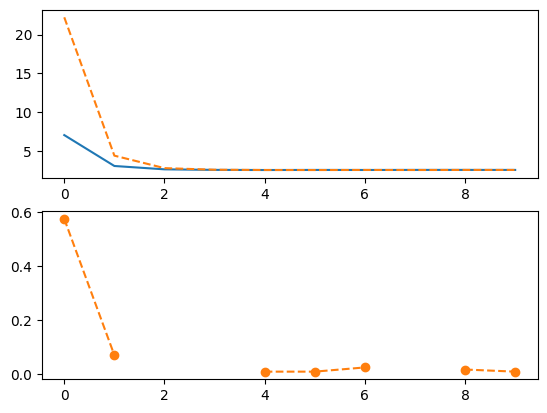

In [648]:
fig, (ax1,ax2) = plt.subplots(2,1)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)

ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')

ax2.scatter(history.epoch, k)
ax2.scatter(history.epoch, j)
ax2.plot(history.epoch, k,'-')
ax2.plot(history.epoch, j,'--')
# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')

In [508]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [509]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()
# unlabeled_test_sequence = pca.transform(unlabeled_test_sequence)

In [510]:
unlabeled_test_sequence.shape

(350, 80933)

In [516]:
y = model.predict(unlabeled_test_sequence)

11/11 [==============================] - 0s 5ms/step


In [517]:
y

array([[0.35775533],
       [0.34519896],
       [0.35017788],
       [0.34407687],
       [0.34666523],
       [0.34407687],
       [0.34486705],
       [0.35100532],
       [0.3458154 ],
       [0.540002  ],
       [0.35489982],
       [0.3553029 ],
       [0.34460977],
       [0.35777122],
       [0.34407687],
       [0.35511515],
       [0.34407687],
       [0.38512403],
       [0.3473187 ],
       [0.34875947],
       [0.3488631 ],
       [0.34650233],
       [0.34407687],
       [0.34407687],
       [0.3770331 ],
       [0.6750486 ],
       [0.35340336],
       [0.3474783 ],
       [0.34642524],
       [0.3572235 ],
       [0.34910658],
       [0.3551118 ],
       [0.34407687],
       [0.34513488],
       [0.34407687],
       [0.350372  ],
       [0.35440132],
       [0.34879386],
       [0.3564077 ],
       [0.35510084],
       [0.35527146],
       [0.34428728],
       [0.35631803],
       [0.3451753 ],
       [0.34823427],
       [0.34473327],
       [0.34790844],
       [0.344

In [518]:
# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [519]:
len(z)

350

In [520]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()